Початок навчання...
Epoch [5/50], Loss: 0.008907
Epoch [10/50], Loss: 0.006202
Epoch [15/50], Loss: 0.004705
Epoch [20/50], Loss: 0.004118
Epoch [25/50], Loss: 0.003847
Epoch [30/50], Loss: 0.003620
Epoch [35/50], Loss: 0.003417
Epoch [40/50], Loss: 0.003184
Epoch [45/50], Loss: 0.003044
Epoch [50/50], Loss: 0.002868
Навчання завершено!


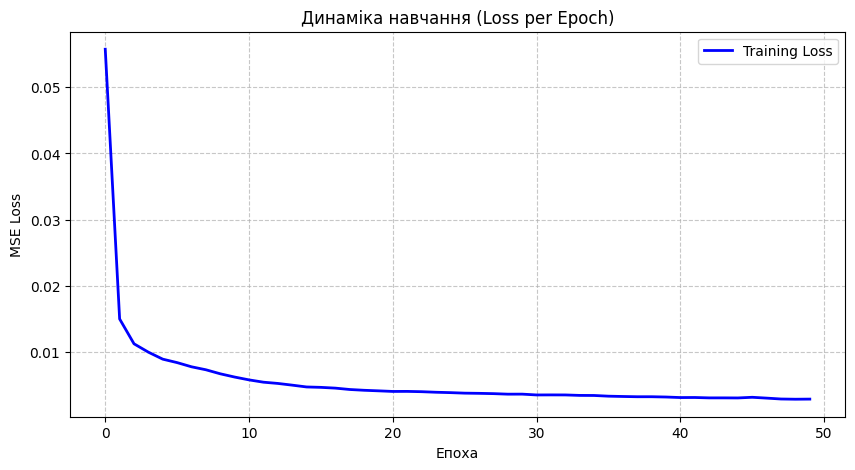

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, precision_score, recall_score, f1_score
import scipy.ndimage

DATA_DIR = 'nut' 
BATCH_SIZE = 16 
LR = 1e-3
EPOCHS = 50   
IMG_SIZE = 256 
LATENT_DIM = 128   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

if not os.path.exists(os.path.join(DATA_DIR, 'train')):
    raise FileNotFoundError(f"Папка {DATA_DIR}/train не знайдена!")

train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256)
        )
        
        self.flatten = nn.Flatten()

        self.linear_enc = nn.Sequential(
            nn.Linear(256 * 16 * 16, LATENT_DIM),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.linear_dec = nn.Sequential(
            nn.Linear(LATENT_DIM, 256 * 16 * 16),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.unflatten = nn.Unflatten(1, (256, 16, 16))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.linear_enc(x)
        x = self.linear_dec(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Початок навчання...")
model.train()

loss_history = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        
        output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")

print("Навчання завершено!")

def plot_training_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history, label='Training Loss', color='blue', linewidth=2)
    plt.title('Динаміка навчання (Loss per Epoch)')
    plt.xlabel('Епоха')
    plt.ylabel('MSE Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

plot_training_loss(loss_history)



Оцінка (Метрики + ROC)
AUROC:       0.7801
Best Thresh: 0.1308
------------------------------
Recall (Sensitivity): 0.7742
Specificity:          0.7273
Precision:            0.9231
F1-Score:             0.8421
------------------------------


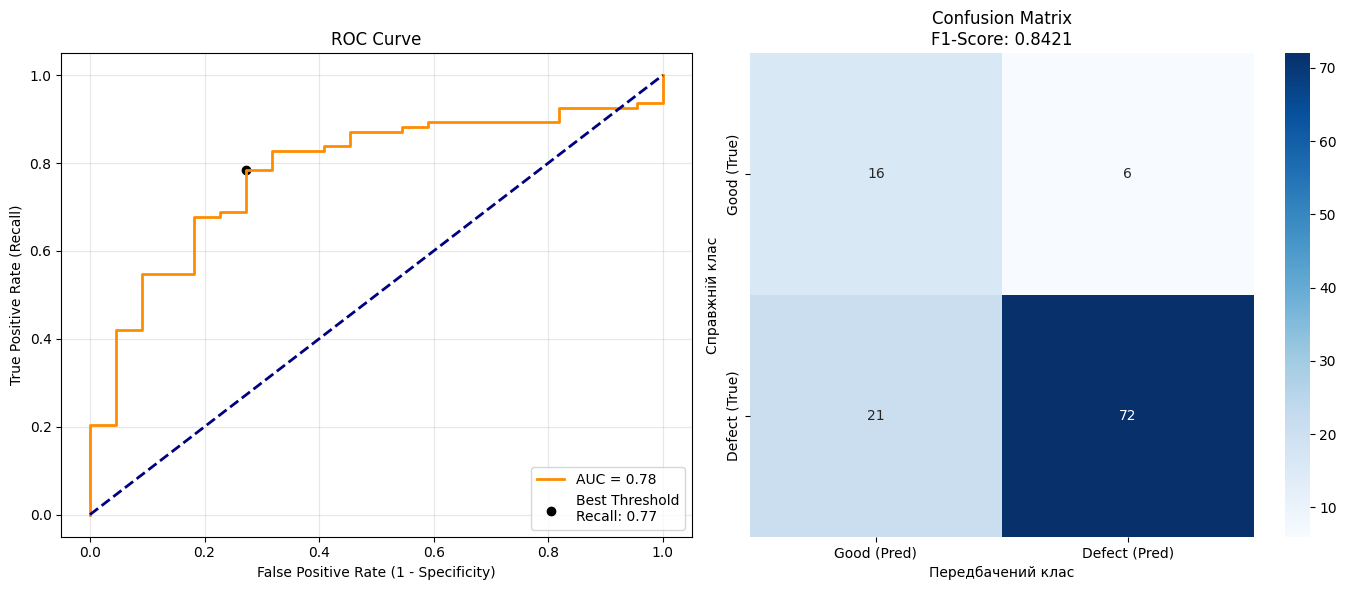


--- Тест на прикладах ---


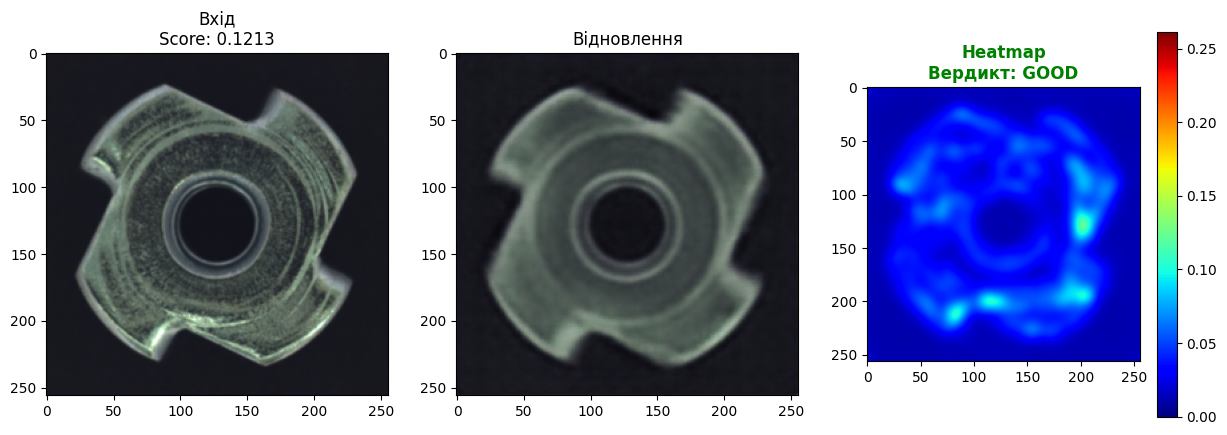

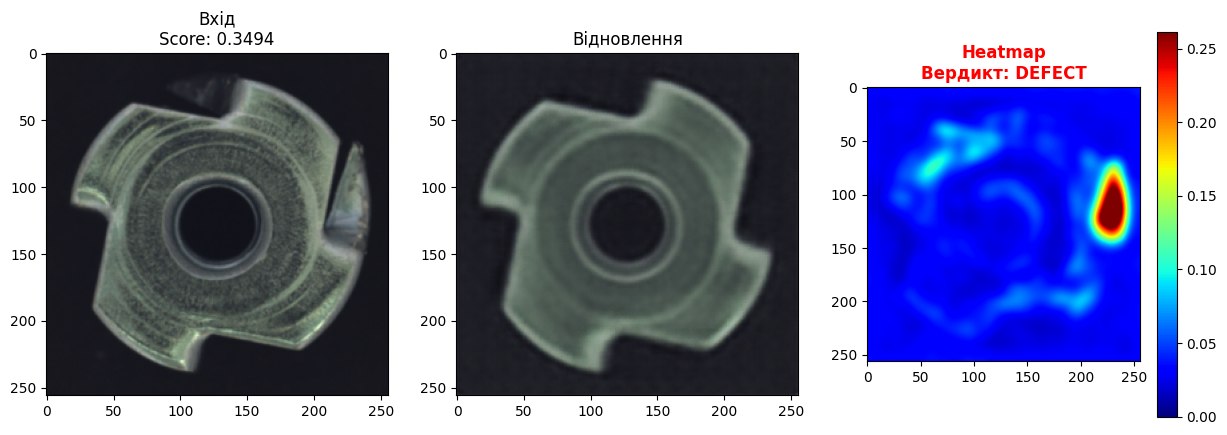

In [74]:
def get_large_defect_map(img_tensor, recon_tensor):
    img_np = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_np = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    
    img_blurred = scipy.ndimage.gaussian_filter(img_np, sigma=2)
    
    diff_map = np.mean(np.abs(img_blurred - recon_np), axis=2)
    
    heatmap = scipy.ndimage.gaussian_filter(diff_map, sigma=6)
    
    return heatmap

def evaluate_with_confusion_matrix(model, data_dir):
    print("\nОцінка (Метрики + ROC)")
    model.eval()
    y_true, y_scores = [], []
    
    test_dir = os.path.join(data_dir, 'test')
    classes = os.listdir(test_dir)
    
    with torch.no_grad():
        for cls in classes:
            label = 0 if cls == 'good' else 1
            class_path = os.path.join(test_dir, cls)
            if not os.path.isdir(class_path): continue
            for file_name in os.listdir(class_path):
                if not file_name.lower().endswith(('.png', '.jpg')): continue
                img_path = os.path.join(class_path, file_name)
                image = Image.open(img_path).convert('RGB')
                input_tensor = data_transforms(image).unsqueeze(0).to(device)
                recon = model(input_tensor)
                anomaly_map = get_large_defect_map(input_tensor, recon)
                score = np.max(anomaly_map)
                y_true.append(label)
                y_scores.append(score)
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    auroc = roc_auc_score(y_true, y_scores)
    fpr_list, tpr_list, thresholds = roc_curve(y_true, y_scores)
    ix = np.argmax(tpr_list - fpr_list)
    best_thresh = thresholds[ix]
    
    y_pred = (y_scores > best_thresh).astype(int)
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"AUROC:       {auroc:.4f}")
    print(f"Best Thresh: {best_thresh:.4f}")
    print("-" * 30)
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity:          {specificity:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"F1-Score:             {f1:.4f}")
    print("-" * 30)

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(fpr_list, tpr_list, color='darkorange', lw=2, label=f'AUC = {auroc:.2f}')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].scatter(fpr_list[ix], tpr_list[ix], marker='o', color='black', label=f'Best Threshold\nRecall: {recall:.2f}')
    ax[0].set_xlabel('False Positive Rate (1 - Specificity)')
    ax[0].set_ylabel('True Positive Rate (Recall)')
    ax[0].set_title('ROC Curve')
    ax[0].legend(loc="lower right")
    ax[0].grid(alpha=0.3)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Good (Pred)', 'Defect (Pred)'],
                yticklabels=['Good (True)', 'Defect (True)'], ax=ax[1])
    ax[1].set_title(f'Confusion Matrix\nF1-Score: {f1:.4f}')
    ax[1].set_ylabel('Справжній клас')
    ax[1].set_xlabel('Передбачений клас')

    plt.tight_layout()
    plt.show()
    
    return best_thresh

def visualize_with_threshold(image_path, model, threshold):
    if not os.path.exists(image_path): return

    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = data_transforms(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        recon = model(input_tensor)
    
    heatmap = get_large_defect_map(input_tensor, recon)
    score = np.max(heatmap)
    
    is_defect = score > threshold
    verdict_color = 'red' if is_defect else 'green'
    verdict_text = "DEFECT" if is_defect else "GOOD"

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(input_tensor.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[0].set_title(f"Вхід\nScore: {score:.4f}")
    
    axs[1].imshow(recon.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[1].set_title("Відновлення")
    
    im = axs[2].imshow(heatmap, cmap='jet', vmin=0, vmax=threshold*2)
    axs[2].set_title(f"Heatmap\nВердикт: {verdict_text}", color=verdict_color, fontweight='bold')
    
    plt.colorbar(im, ax=axs[2])
    plt.show()

best_threshold = evaluate_with_confusion_matrix(model, DATA_DIR)

print("\n--- Тест на прикладах ---")
visualize_with_threshold(os.path.join(DATA_DIR, 'test/good/000.png'), model, best_threshold)

test_defect = os.path.join(DATA_DIR, 'test/bent/000.png')
if os.path.exists(test_defect):
    visualize_with_threshold(test_defect, model, best_threshold)

In [73]:
save_path = 'Checkpoint.pth'

checkpoint = {
    'model_state_dict': model.state_dict(),  
    'threshold': best_threshold,             
    'hyperparameters': {             
        'latent_dim': LATENT_DIM,
        'img_size': IMG_SIZE
    }
}

torch.save(checkpoint, save_path)
print(f"Модель збережено: {save_path}")
print(f"Збережений поріг: {best_threshold}")

Модель збережено: Checkpoint.pth
Збережений поріг: 0.13083365559577942
